In [1]:
# Importar as bibliotecas necessárias
from transformers import ViTFeatureExtractor, ViTModel, ViTConfig
from PIL import Image
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

print("Bibliotecas importadas com sucesso.")


Bibliotecas importadas com sucesso.


In [2]:
N_IMGS = 100
# Carregar o conjunto de dados CIFAR-10
from datasets import load_dataset

# Carregando o conjunto de dados
dataset = load_dataset("cifar10", split="train[:1250]")

# Verificando as primeiras entradas do conjunto de dados
#print(dataset['train'][0])


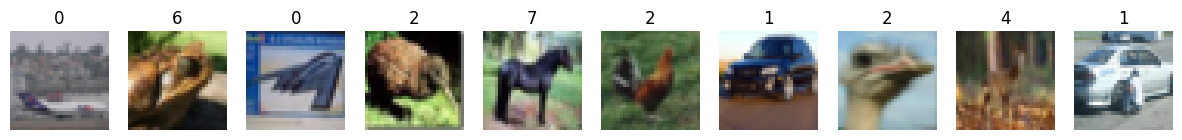

In [3]:
# Função atualizada para mostrar imagens do dataset
def show_images(dataset, num_images=10):
    fig = plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = dataset[i]['img']
        plt.imshow(img)
        plt.title(dataset[i]['label'])
        plt.axis("off")

# Mostrando as imagens
show_images(dataset)


In [4]:
def convert_to_tensor(ds):
    images = [np.array(img) for img in ds['img']]  # Convertendo para arrays NumPy primeiro
    labels = ds['label']
    images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2) / 255  # Normalizar
    labels = torch.tensor(labels, dtype=torch.long)
    return images, labels

train_images, train_labels = convert_to_tensor(dataset[0:1000])
test_images, test_labels = convert_to_tensor(dataset[1000:1250])

print(f"Imagens de treinamento: {train_images.shape}, Rótulos de treinamento: {train_labels.shape}")
print(f"Imagens de teste: {test_images.shape}, Rótulos de teste: {test_labels.shape}")


/var/folders/g9/dlcnl5cd2752fb_17r927ff00000gn/T/ipykernel_12004/3336673573.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2) / 255  # Normalizar


Imagens de treinamento: torch.Size([1000, 3, 32, 32]), Rótulos de treinamento: torch.Size([1000])
Imagens de teste: torch.Size([250, 3, 32, 32]), Rótulos de teste: torch.Size([250])


In [6]:
# Load model and feature extractor for ResNet-50
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")

# Function to extract embeddings using ResNet-50
def extract_embeddings(images, batch_size=128):
    # Resize images to the expected size by the model (224, 224)
    images_resized = torch.nn.functional.interpolate(images, size=(224, 224))
    
    # Split into batches
    dataset = torch.utils.data.TensorDataset(images_resized)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    # Extract embeddings
    embeddings = []
    with torch.no_grad():
        for batch in loader:
            inputs = extractor(images=batch[0], return_tensors="pt")
            outputs = model(**inputs)
            print(outputs[0].shape)
            embeddings.append(outputs[0])

    embeddings = torch.cat(embeddings)
    return embeddings


/Users/josaum/opt/anaconda3/envs/atech-ai/lib/python3.11/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [7]:
train_embeddings = extract_embeddings(train_images)

test_embeddings = extract_embeddings(test_images)

print(f"Train embeddings: {train_embeddings.shape}")
print(f"Test embeddings: {test_embeddings.shape}")

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


torch.Size([128, 1000])
torch.Size([128, 1000])
torch.Size([128, 1000])
torch.Size([128, 1000])
torch.Size([128, 1000])
torch.Size([128, 1000])
torch.Size([128, 1000])
torch.Size([104, 1000])
torch.Size([128, 1000])
torch.Size([122, 1000])
Train embeddings: torch.Size([1000, 1000])
Test embeddings: torch.Size([250, 1000])


In [13]:
# Definir um modelo de classificação simples
class Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(1000, num_classes)  # O tamanho da embedding do ViT é 768 / resnet50 é 1000
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc(x))
        return x

# Criar uma instância do modelo de classificação
classifier = Classifier()
print(classifier)


Classifier(
  (fc): Linear(in_features=1000, out_features=10, bias=True)
  (relu): ReLU()
)


In [14]:
# Função para treinar o modelo
def train_model(model, train_embeddings, train_labels, test_embeddings, test_labels, epochs=10, lr=0.001):
    # Critério e otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Preparar os dados de treinamento
    train_data = torch.utils.data.TensorDataset(train_embeddings, train_labels)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

    # Preparar os dados de teste
    test_data = torch.utils.data.TensorDataset(test_embeddings, test_labels)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

    # Armazenar as perdas e acurácias
    train_losses, test_losses, test_accs = [], [], []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        running_loss = 0
        for embeddings, labels in train_loader:
            optimizer.zero_grad()
            output = model(embeddings)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Avaliação
        model.eval()
        running_loss = 0
        correct_predictions = 0
        with torch.no_grad():
            for embeddings, labels in test_loader:
                output = model(embeddings)
                loss = criterion(output, labels)
                running_loss += loss.item()
                _, preds = torch.max(output, 1)
                correct_predictions += torch.sum(preds == labels)

        test_losses.append(running_loss / len(test_loader))
        test_accs.append(correct_predictions.float() / len(test_data))

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train loss: {train_losses[-1]:.4f}, "
              f"Test loss: {test_losses[-1]:.4f}, "
              f"Test accuracy: {test_accs[-1]:.4f}")

    return train_losses, test_losses, test_accs

# Treinar o modelo
train_losses, test_losses, test_accs = train_model(
    classifier, train_embeddings, train_labels, test_embeddings, test_labels, epochs=100, lr=0.00001
)


Epoch 1/100 - Train loss: 2.7241, Test loss: 2.5064, Test accuracy: 0.1040
Epoch 2/100 - Train loss: 2.4294, Test loss: 2.3350, Test accuracy: 0.1040
Epoch 3/100 - Train loss: 2.3204, Test loss: 2.3001, Test accuracy: 0.1040
Epoch 4/100 - Train loss: 2.3024, Test loss: 2.3014, Test accuracy: 0.1120
Epoch 5/100 - Train loss: 2.3024, Test loss: 2.3025, Test accuracy: 0.1160
Epoch 6/100 - Train loss: 2.3023, Test loss: 2.3025, Test accuracy: 0.1040
Epoch 7/100 - Train loss: 2.3023, Test loss: 2.3025, Test accuracy: 0.1040
Epoch 8/100 - Train loss: 2.3026, Test loss: 2.3026, Test accuracy: 0.1040
Epoch 9/100 - Train loss: 2.3026, Test loss: 2.3025, Test accuracy: 0.1040
Epoch 10/100 - Train loss: 2.3026, Test loss: 2.3025, Test accuracy: 0.1040
Epoch 11/100 - Train loss: 2.3023, Test loss: 2.3025, Test accuracy: 0.1040
Epoch 12/100 - Train loss: 2.3029, Test loss: 2.3025, Test accuracy: 0.1040
Epoch 13/100 - Train loss: 2.3029, Test loss: 2.3025, Test accuracy: 0.1040
Epoch 14/100 - Train 

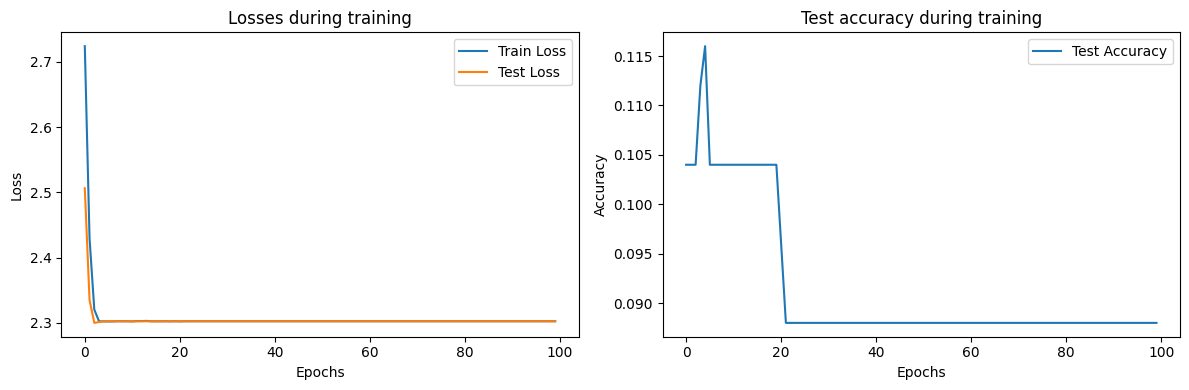

In [15]:
# Plotar as curvas de perda e acurácia
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses during training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test accuracy during training')
plt.legend()

plt.tight_layout()
plt.show()
